In [1]:
import sys
import os

# To make our imports work because python relative imports suck
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [2]:
import re
import torch

import pandas as pd

from datasets import load_dataset
from tqdm import tqdm

# Local Modules
from Architecture import Tokenizer, VOCAB_SIZE
from Architecture.ModelConfig import ModelConfig
from Architecture.Decoder import DecoderDataset

/Users/faustogerman/miniforge3/envs/CodeNetSentinel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CONFIG = ModelConfig()

torch.manual_seed(CONFIG.random_seed)
# np.rand
torch.__version__

'2.1.2'

In [4]:
dataset = load_dataset("Safurai/Code-Instruct-700k")
dataset = pd.DataFrame(dataset["train"])[["programming_language", "response"]]

dataset

,programming_language,response
0,C#,\nHere's some sample code that demonstrates ho...
1,Julia,\nHere is a possible implementation of this fu...
2,TypeScript,\nHere is a possible implementation of your re...
3,C#,\nHere's some sample code written in C#:\n\n ...
4,Ruby,\nHere is some sample ruby code which implemen...
...,...,...
699995,JavaScript,\nHere is some sample Javascript code which de...
699996,relation database and SQL,\nHere is a possible relational database schem...
699997,C++,\nHere is some sample C++ code which implement...
699998,Rust,\nHere is some sample Rust code which implemen...


In [5]:
def extract_code(res):
    extracted = re.findall('`{3}([\s\S]*?)`{3}', res)

    # Two major assumptions:
    # 1. The code we're interested in is enclosed between triple backticks
    # 2. The text between the first triple backticks and the first '\n' is
    #    the name of the programming language in the response
    if len(extracted) > 0:
        return Tokenizer.bos_token + "###" + extracted[0] + Tokenizer.eos_token
    else:
        return None

dataset['response'] = dataset['response'].apply(extract_code)

dataset

,programming_language,response
0,C#,[BOS]###c#\n// Define variables\nstring custom...
1,Julia,None
2,TypeScript,[BOS]###typescript \nfunction determineExtreme...
3,C#,[BOS]###csharp\n // This function takes two...
4,Ruby,[BOS]###ruby \n# Define constants for interest...
...,...,...
699995,JavaScript,[BOS]###javascript \n// Function to determine ...
699996,relation database and SQL,[BOS]###sql\n CREATE TABLE `location` (\n ...
699997,C++,[BOS]###c++\n#include <iostream>\nusing namesp...
699998,Rust,[BOS]###rust\nfn check_hygiene(consent: bool) ...


In [6]:
dataset = dataset[~dataset["response"].isna()].sample(
    n=200_000,
    random_state=CONFIG.random_seed
)["response"]

dataset

146679    [BOS]###typescript\nfunction transformExtremeE...
187448    [BOS]###ruby \n# Define constants for exam typ...
302090    [BOS]###c#\n    // Function Name: CalculateExt...
164188    [BOS]###rust\n    fn check_low_fitness(reliabi...
71775     [BOS]###python \ndef display_high_clothing_sta...
                                ...                        
682844    [BOS]###sql\n    CREATE TABLE IF NOT EXISTS `c...
441806    [BOS]###go \npackage main\nimport "fmt"\nfunc ...
647054    [BOS]###julia\nmodule CheckExtremeDentalHygien...
405504    [BOS]###rust \nfn transform_high_food_hygiene(...
305484    [BOS]###javascript\n    function checkHairCare...
Name: response, Length: 200000, dtype: object

In [7]:
tokenized_sequences = {
    "inputs": [],
    "attn_masks": [],
    "targets": []
}

tokenizer_batch_size = 64
for idx_start in tqdm(range(0, len(dataset), tokenizer_batch_size)):
    idx_end = idx_start+tokenizer_batch_size

    tokenized_batch = Tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=dataset[idx_start:idx_end].tolist(),
        truncation=True,
        max_length=CONFIG.max_seq_len + 1, # +1 to account for target shift
        padding="max_length",
        stride=CONFIG.tokenized_stride,
        return_tensors="pt",
        return_overflowing_tokens=True,
        return_attention_mask=True
    )

    tokenized_sequences["inputs"].extend(tokenized_batch["input_ids"][:, :-1])
    tokenized_sequences["attn_masks"].extend(~(tokenized_batch["attention_mask"][:, :-1].bool()))
    tokenized_sequences["targets"].extend(tokenized_batch["input_ids"][:, 1:])

100%|██████████| 3125/3125 [01:13<00:00, 42.24it/s]


In [8]:
DATA = DecoderDataset(tokenized_sequences, VOCAB_SIZE)
len(DATA)

220822

array([[<Axes: title={'center': 'Input Lengths'}>]], dtype=object)

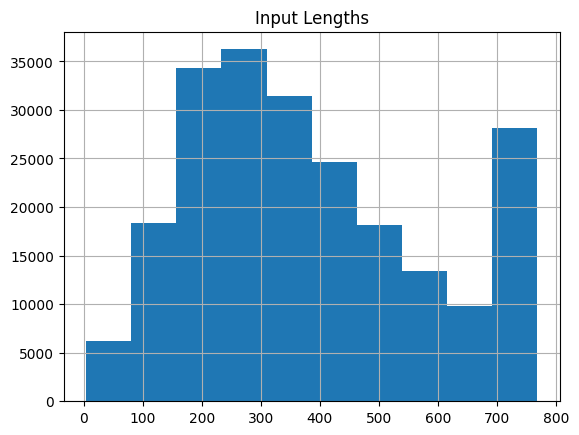

In [9]:
pd.DataFrame(CONFIG.max_seq_len - DATA.attn_masks.sum(axis=1), columns=["Input Lengths"]).hist()

In [10]:
print(Tokenizer.decode(DATA[0]["inputs"]))

[BOS]###typescript
function transformExtremeEarHygiene(dryRun = false) {
  // Define variables
  let actionTaken = "";

  // Determine whether ear wax removal is necessary
  const needsRemoval = true;
  
  // If dry run is not requested, determine appropriate course of action 
  if (!dryRun && needsRemoval) {
    actionTaken = "Have patient use cotton swabs gently to remove excess ear wax";
  } else if (dryRun) {
    console.log("Dry Run: No action taken");
  } else {
    actionTaken = "No action needed - no evidence of ear wax buildup";
  }

  return `Action Taken: ${actionTaken}`;
}

// Call the function and print the result
console.log(transformExtremeEarHygiene());  // Action Taken: Have patient use cotton swabs gently to remove excess ear wax
console.log(transformExtremeEarHygiene(true)); // Dry Run: No action taken
[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

In [11]:
print(Tokenizer.decode(DATA[0]["targets"]))

###typescript
function transformExtremeEarHygiene(dryRun = false) {
  // Define variables
  let actionTaken = "";

  // Determine whether ear wax removal is necessary
  const needsRemoval = true;
  
  // If dry run is not requested, determine appropriate course of action 
  if (!dryRun && needsRemoval) {
    actionTaken = "Have patient use cotton swabs gently to remove excess ear wax";
  } else if (dryRun) {
    console.log("Dry Run: No action taken");
  } else {
    actionTaken = "No action needed - no evidence of ear wax buildup";
  }

  return `Action Taken: ${actionTaken}`;
}

// Call the function and print the result
console.log(transformExtremeEarHygiene());  // Action Taken: Have patient use cotton swabs gently to remove excess ear wax
console.log(transformExtremeEarHygiene(true)); // Dry Run: No action taken
[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

In [ ]:
DATA.save_to("./data/decoder_data.pt")